In [1]:
import pandas as pd
import numpy as np
import time
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score,accuracy_score

In [2]:
import matplotlib
%matplotlib inline 
matplotlib.rc('font', family='AppleGothic')

plt.rcParams["figure.figsize"] = (20,75)

In [3]:
class evaluation:
    def __init__(self, true_s):
        self.true_df = pd.DataFrame(true_s)
        self.true_df.columns = ['swell']
        self.true_df['swell(t+1)'] = self.true_df['swell'].shift(-1)
        self.true_df['swell(t+2)'] = self.true_df['swell'].shift(-2)
        self.true_df['swell(t-1)'] = self.true_df['swell'].shift(1)
        self.true_df['swell(t-2)'] = self.true_df['swell'].shift(2)
    
        self.swell_columns = ['swell(t+1)','swell(t+2)','swell(t-1)','swell(t-2)']
    
    def _eval_one(self, pred):
        true = self.true_df.loc[pred.name]
        swell = true['swell'] 
        p_swell = pred['pred']

        if swell == 0 and p_swell == 0:
            return 1

        if swell == 1 and p_swell == 1:
            return 2

        if swell == 0 and p_swell == 1:
            if (true[self.swell_columns].values == 1).any():
                return 0
            else:
                return -1

        if swell == 1 and p_swell == 0:
            if (pred[self.swell_columns].values == 1).any():
                return 0
            else: 
                return -2
    
    def evaluate(self, pred):
        pred_df = pd.DataFrame(pred)
        pred_df.columns = ['pred']
        pred_df['swell(t+1)'] = pred_df['pred'].shift(-1)
        pred_df['swell(t+2)'] = pred_df['pred'].shift(-2)
        pred_df['swell(t-1)'] = pred_df['pred'].shift(1)
        pred_df['swell(t-2)'] = pred_df['pred'].shift(2)

        result = []
        for index in pred_df.index:
            result.append(self._eval_one(pred_df.loc[index]))
        
        #print(result)
        print(pd.Series(result).value_counts())
        
        #print(result)
        return np.sum(result)

In [4]:
df = pd.read_csv('./all_merged_info_data.tsv',sep='\t',index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 90 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_일시                 33979 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_일시                 19639 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 no

In [5]:
df.drop([col for col in df.columns if '일시' in col],axis=1,inplace=True)

In [6]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [7]:
df['swell'] = df['swell']# + df['weather_deterioration']

In [8]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [9]:
def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:8])
    day = datetime(y, m, d)
    return day.weekday()

In [10]:
# 음력 추가
from korean_lunar_calendar import KoreanLunarCalendar
from datetime import datetime

def add_lunar_date(df):
    calendar = KoreanLunarCalendar()
    
    lunar_y = []
    lunar_m = []
    lunar_d = []
    for y, m, d in zip (df['year'], df['month'], df['day']):
        calendar.setSolarDate(y, m, d)
        lunar_date = calendar.LunarIsoFormat()
        lunar_y.append(int(lunar_date[:4]))
        lunar_m.append(int(lunar_date[5:7]))
        lunar_d.append(int(lunar_date[8:10]))
        
    df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d


In [11]:
df['month'] = df['hour'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['hour'].apply(lambda x:int(str(x)[6:8]))
df['day_hour'] = df['hour'].apply(lambda x:int((str(x)[8:])))
df['week'] = df['hour'].apply(date2week)
df['weekday'] = df['week'] + 1 
df['year'] = df['hour'].apply(lambda x:int(str(x)[:4]))

In [12]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    df.drop(['month', 'lunar_month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    df.drop(['day', 'lunar_day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]
    df.drop(['weekday'],axis=1,inplace=True)
    df.drop(['week'],axis=1,inplace=True)

In [13]:
%%time
add_lunar_date(df)

CPU times: user 2min 18s, sys: 438 ms, total: 2min 18s
Wall time: 2min 18s


In [14]:
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [15]:
s = (df[df['swell'].isnull()]['hour']//100).value_counts()
s

20170315    17
20171211    17
20161130    17
20170331    17
20141023    17
20161020    17
20140518    17
20170212    17
20150718    17
20140706    17
20150627    17
20160830    17
20171023    17
20171012    17
20141221    17
20170916    17
20160122    17
20150404    17
20150113    17
20140925    17
20170603    17
20161226    17
20151213    17
20160304    17
20151113    17
20160831     7
20170604     7
20171024     7
20140926     7
20171013     7
20150114     7
20141222     7
20151214     7
20150405     7
20150628     7
20140707     7
20150719     7
20170401     7
20171212     7
20170917     7
20151114     7
20170213     7
20140519     7
20160305     7
20161021     7
20170316     7
20161227     7
20161201     7
20160123     7
20141024     7
Name: hour, dtype: int64

In [16]:
s[s > 10].index.tolist()[0]

20170315

In [17]:
def get_prev_date(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return (today - timedelta(1)).strftime('%Y%m%d%H')

In [18]:
def get_today_from_07(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return today.strftime('%Y%m%d%H')

In [19]:
get_prev_date('20170101')

'2016123100'

In [20]:
get_today_from_07('20170101')

'2017010100'

In [21]:
s[s>10].index.astype(str).sort_values()

Index(['20140518', '20140706', '20140925', '20141023', '20141221', '20150113',
       '20150404', '20150627', '20150718', '20151113', '20151213', '20160122',
       '20160304', '20160830', '20161020', '20161130', '20161226', '20170212',
       '20170315', '20170331', '20170603', '20170916', '20171012', '20171023',
       '20171211'],
      dtype='object')

In [22]:
test_date_hour = []
for d in s[s>10].index.astype(str):
    #day = get_prev_date(d)
    day = get_prev_date(d)
    #day = get_today_from_07(d)
    tomorrow_day = int(day) +  100 
    
    if tomorrow_day == 2016113100:
        tomorrow_day = 2016120100

    if tomorrow_day == 2017033200:
        tomorrow_day = 2017040100
        
    print(day, tomorrow_day)
    for hour in range(7,24):
        test_date_hour.append((int(day) + hour))
            
    for hour in range(0,7):
        test_date_hour.append((tomorrow_day + hour))

test_date_hour = list(map(str,test_date_hour))
len(test_date_hour)

2017031400 2017031500
2017121000 2017121100
2016112900 2016113000
2017033000 2017033100
2014102200 2014102300
2016101900 2016102000
2014051700 2014051800
2017021100 2017021200
2015071700 2015071800
2014070500 2014070600
2015062600 2015062700
2016082900 2016083000
2017102200 2017102300
2017101100 2017101200
2014122000 2014122100
2017091500 2017091600
2016012100 2016012200
2015040300 2015040400
2015011200 2015011300
2014092400 2014092500
2017060200 2017060300
2016122500 2016122600
2015121200 2015121300
2016030300 2016030400
2015111200 2015111300


600

In [23]:
df['swell(t+1)'] = df['swell'].shift(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 97 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 non-null float64
21229_수온(°C)             34629 non-null float64
21229_습도(%)              33939 no

In [24]:
def output_change(x):
    if x == 2:
        return 1
    else:
        return 0

In [25]:
df['hour'] = df['hour'].astype(str)
df['index'] = df.index
df.set_index('hour',inplace=True,)

In [26]:
df.columns

Index(['climate', 'weather_deterioration', 'swell', '22453_수온(°C)',
       '22453_최대파고(m)', '22453_유의파고(m)', '22453_평균파고(m)', '22453_파주기(sec)',
       '22490_수온(°C)', '22490_최대파고(m)', '22490_유의파고(m)', '22490_평균파고(m)',
       '22490_파주기(sec)', '21229_GUST풍속 1(m/s)', '21229_GUST풍속(m/s)',
       '21229_기온(°C)', '21229_수온(°C)', '21229_습도(%)', '21229_유의파고(m)',
       '21229_최대파고(m)', '21229_파주기(sec)', '21229_파향(deg)', '21229_평균파고(m)',
       '21229_풍속(m/s)', '21229_풍속1(m/s)', '21229_풍향(deg)', '21229_풍향1(deg)',
       '21229_현지기압(hPa)', '22105_GUST풍속 1(m/s)', '22105_GUST풍속(m/s)',
       '22105_기온(°C)', '22105_수온(°C)', '22105_습도(%)', '22105_유의파고(m)',
       '22105_최대파고(m)', '22105_파주기(sec)', '22105_파향(deg)', '22105_평균파고(m)',
       '22105_풍속(m/s)', '22105_풍속1(m/s)', '22105_풍향(deg)', '22105_풍향1(deg)',
       '22105_현지기압(hPa)', '22106_GUST풍속 1(m/s)', '22106_GUST풍속(m/s)',
       '22106_기온(°C)', '22106_수온(°C)', '22106_습도(%)', '22106_유의파고(m)',
       '22106_최대파고(m)', '22106_파주기(sec)', '22106_파향(de

### 테스트 데이터 하나당 feature selection을 수행

In [27]:
test_date_hour = sorted(test_date_hour)
test_date_hour

['2014051707',
 '2014051708',
 '2014051709',
 '2014051710',
 '2014051711',
 '2014051712',
 '2014051713',
 '2014051714',
 '2014051715',
 '2014051716',
 '2014051717',
 '2014051718',
 '2014051719',
 '2014051720',
 '2014051721',
 '2014051722',
 '2014051723',
 '2014051800',
 '2014051801',
 '2014051802',
 '2014051803',
 '2014051804',
 '2014051805',
 '2014051806',
 '2014070507',
 '2014070508',
 '2014070509',
 '2014070510',
 '2014070511',
 '2014070512',
 '2014070513',
 '2014070514',
 '2014070515',
 '2014070516',
 '2014070517',
 '2014070518',
 '2014070519',
 '2014070520',
 '2014070521',
 '2014070522',
 '2014070523',
 '2014070600',
 '2014070601',
 '2014070602',
 '2014070603',
 '2014070604',
 '2014070605',
 '2014070606',
 '2014092407',
 '2014092408',
 '2014092409',
 '2014092410',
 '2014092411',
 '2014092412',
 '2014092413',
 '2014092414',
 '2014092415',
 '2014092416',
 '2014092417',
 '2014092418',
 '2014092419',
 '2014092420',
 '2014092421',
 '2014092422',
 '2014092423',
 '2014092500',
 '20140925

### col 중 20% 이상의 미싱벨류가 있는 경우 삭제

In [28]:
drop_features = ['swell(t+1)','swell','weather_deterioration','index','climate']

In [29]:
%%time

model_scores = []
imp_features = []
preds = [] 
probas = []

for i,test_date in enumerate(test_date_hour):
    st = time.time()
    all_df = df.loc[:test_date]
   
    all_size = len(all_df)
    col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.2)
    possible_cols = col_df[col_df[0]==True].index.tolist()
    possible_df = all_df[possible_cols].copy()
    possible_df.fillna(method='ffill',inplace=True)
    
    train_X = possible_df.iloc[:-1].drop(drop_features,axis=1)
    train_y = possible_df.iloc[:-1]['swell(t+1)']
    
    test_X = pd.DataFrame(possible_df.iloc[-1]).T\
                .drop(drop_features,axis=1)
    test_y = pd.DataFrame(possible_df.iloc[-1]).T\
                ['swell(t+1)']
    
    model = RandomForestClassifier(n_estimators=150,n_jobs=4)
    model.fit(train_X,train_y)
    
    pred = model.predict_proba(test_X)
    preds.append(np.argmax(pred[0]))
    probas.append(pred[0])
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    imp_features.append(train_X.columns[indices].tolist())
    print(i,'training {} ~ {} size: {}, test {}, {} sec done - pred:{} real:{}, {}'\
              .format(train_X.index[0],train_X.index[-1], len(train_X),test_X.index[0],round(time.time()-st,2),
                      pred[0],test_y[0],np.argmax(pred[0]) == test_y[0]))

0 training 2014010407 ~ 2014051706 size: 3192, test 2014051707, 0.7 sec done - pred:[ 0.93333333  0.06666667] real:0.0, True
1 training 2014010407 ~ 2014051707 size: 3193, test 2014051708, 0.56 sec done - pred:[ 0.9  0.1] real:0.0, True
2 training 2014010407 ~ 2014051708 size: 3194, test 2014051709, 0.56 sec done - pred:[ 0.96  0.04] real:0.0, True
3 training 2014010407 ~ 2014051709 size: 3195, test 2014051710, 0.71 sec done - pred:[ 0.88666667  0.11333333] real:0.0, True
4 training 2014010407 ~ 2014051710 size: 3196, test 2014051711, 0.7 sec done - pred:[ 0.91333333  0.08666667] real:0.0, True
5 training 2014010407 ~ 2014051711 size: 3197, test 2014051712, 0.69 sec done - pred:[ 0.96666667  0.03333333] real:1.0, False
6 training 2014010407 ~ 2014051712 size: 3198, test 2014051713, 0.66 sec done - pred:[ 0.52666667  0.47333333] real:1.0, False
7 training 2014010407 ~ 2014051713 size: 3199, test 2014051714, 0.68 sec done - pred:[ 0.32666667  0.67333333] real:1.0, True
8 training 2014010

68 training 2014010407 ~ 2014092502 size: 6332, test 2014092503, 0.77 sec done - pred:[ 0.96666667  0.03333333] real:0.0, True
69 training 2014010407 ~ 2014092503 size: 6333, test 2014092504, 0.77 sec done - pred:[ 0.96  0.04] real:0.0, True
70 training 2014010407 ~ 2014092504 size: 6334, test 2014092505, 0.76 sec done - pred:[ 0.95333333  0.04666667] real:0.0, True
71 training 2014010407 ~ 2014092505 size: 6335, test 2014092506, 0.76 sec done - pred:[ 0.93333333  0.06666667] real:0.0, True
72 training 2014010407 ~ 2014102206 size: 6984, test 2014102207, 0.78 sec done - pred:[ 0.96666667  0.03333333] real:0.0, True
73 training 2014010407 ~ 2014102207 size: 6985, test 2014102208, 0.78 sec done - pred:[ 0.96666667  0.03333333] real:0.0, True
74 training 2014010407 ~ 2014102208 size: 6986, test 2014102209, 0.87 sec done - pred:[ 0.94666667  0.05333333] real:0.0, True
75 training 2014010407 ~ 2014102209 size: 6987, test 2014102210, 0.77 sec done - pred:[ 0.87333333  0.12666667] real:0.0, T

135 training 2014010407 ~ 2015011221 size: 8967, test 2015011222, 1.0 sec done - pred:[ 0.22666667  0.77333333] real:1.0, True
136 training 2014010407 ~ 2015011222 size: 8968, test 2015011223, 0.97 sec done - pred:[ 0.08666667  0.91333333] real:1.0, True
137 training 2014010407 ~ 2015011223 size: 8969, test 2015011300, 1.0 sec done - pred:[ 0.26  0.74] real:1.0, True
138 training 2014010407 ~ 2015011300 size: 8970, test 2015011301, 0.99 sec done - pred:[ 0.19333333  0.80666667] real:1.0, True
139 training 2014010407 ~ 2015011301 size: 8971, test 2015011302, 1.12 sec done - pred:[ 0.17333333  0.82666667] real:1.0, True
140 training 2014010407 ~ 2015011302 size: 8972, test 2015011303, 1.08 sec done - pred:[ 0.09333333  0.90666667] real:1.0, True
141 training 2014010407 ~ 2015011303 size: 8973, test 2015011304, 1.19 sec done - pred:[ 0.13333333  0.86666667] real:1.0, True
142 training 2014010407 ~ 2015011304 size: 8974, test 2015011305, 0.98 sec done - pred:[ 0.08  0.92] real:1.0, True
14

202 training 2014010407 ~ 2015071716 size: 13426, test 2015071717, 1.08 sec done - pred:[ 0.16  0.84] real:1.0, True
203 training 2014010407 ~ 2015071717 size: 13427, test 2015071718, 1.09 sec done - pred:[ 0.27333333  0.72666667] real:1.0, True
204 training 2014010407 ~ 2015071718 size: 13428, test 2015071719, 1.08 sec done - pred:[ 0.36666667  0.63333333] real:1.0, True
205 training 2014010407 ~ 2015071719 size: 13429, test 2015071720, 1.09 sec done - pred:[ 0.51333333  0.48666667] real:1.0, False
206 training 2014010407 ~ 2015071720 size: 13430, test 2015071721, 1.08 sec done - pred:[ 0.28666667  0.71333333] real:1.0, True
207 training 2014010407 ~ 2015071721 size: 13431, test 2015071722, 1.08 sec done - pred:[ 0.3  0.7] real:1.0, True
208 training 2014010407 ~ 2015071722 size: 13432, test 2015071723, 1.08 sec done - pred:[ 0.13333333  0.86666667] real:1.0, True
209 training 2014010407 ~ 2015071723 size: 13433, test 2015071800, 1.09 sec done - pred:[ 0.56666667  0.43333333] real:1.0

268 training 2014010407 ~ 2016012110 size: 17932, test 2016012111, 1.4 sec done - pred:[ 0.07333333  0.92666667] real:1.0, True
269 training 2014010407 ~ 2016012111 size: 17933, test 2016012112, 1.41 sec done - pred:[ 0.05333333  0.94666667] real:1.0, True
270 training 2014010407 ~ 2016012112 size: 17934, test 2016012113, 1.41 sec done - pred:[ 0.18666667  0.81333333] real:1.0, True
271 training 2014010407 ~ 2016012113 size: 17935, test 2016012114, 1.41 sec done - pred:[ 0.16  0.84] real:1.0, True
272 training 2014010407 ~ 2016012114 size: 17936, test 2016012115, 1.3 sec done - pred:[ 0.06666667  0.93333333] real:1.0, True
273 training 2014010407 ~ 2016012115 size: 17937, test 2016012116, 1.3 sec done - pred:[ 0.16  0.84] real:1.0, True
274 training 2014010407 ~ 2016012116 size: 17938, test 2016012117, 1.3 sec done - pred:[ 0.06666667  0.93333333] real:1.0, True
275 training 2014010407 ~ 2016012117 size: 17939, test 2016012118, 1.4 sec done - pred:[ 0.26  0.74] real:1.0, True
276 train

335 training 2014010407 ~ 2016083005 size: 23255, test 2016083006, 1.61 sec done - pred:[ 0.10666667  0.89333333] real:1.0, True
336 training 2014010407 ~ 2016101906 size: 24456, test 2016101907, 1.72 sec done - pred:[ 0.99333333  0.00666667] real:0.0, True
337 training 2014010407 ~ 2016101907 size: 24457, test 2016101908, 1.73 sec done - pred:[ 1.  0.] real:0.0, True
338 training 2014010407 ~ 2016101908 size: 24458, test 2016101909, 1.73 sec done - pred:[ 0.99333333  0.00666667] real:0.0, True
339 training 2014010407 ~ 2016101909 size: 24459, test 2016101910, 1.73 sec done - pred:[ 1.  0.] real:0.0, True
340 training 2014010407 ~ 2016101910 size: 24460, test 2016101911, 1.73 sec done - pred:[ 1.  0.] real:0.0, True
341 training 2014010407 ~ 2016101911 size: 24461, test 2016101912, 1.72 sec done - pred:[ 0.99333333  0.00666667] real:0.0, True
342 training 2014010407 ~ 2016101912 size: 24462, test 2016101913, 1.72 sec done - pred:[ 1.  0.] real:0.0, True
343 training 2014010407 ~ 201610

403 training 2014010407 ~ 2016122601 size: 26083, test 2016122602, 1.95 sec done - pred:[ 0.91333333  0.08666667] real:0.0, True
404 training 2014010407 ~ 2016122602 size: 26084, test 2016122603, 1.84 sec done - pred:[ 0.86666667  0.13333333] real:0.0, True
405 training 2014010407 ~ 2016122603 size: 26085, test 2016122604, 1.84 sec done - pred:[ 0.93333333  0.06666667] real:0.0, True
406 training 2014010407 ~ 2016122604 size: 26086, test 2016122605, 1.86 sec done - pred:[ 0.98  0.02] real:0.0, True
407 training 2014010407 ~ 2016122605 size: 26087, test 2016122606, 1.85 sec done - pred:[ 0.96666667  0.03333333] real:0.0, True
408 training 2014010407 ~ 2017021106 size: 27216, test 2017021107, 2.04 sec done - pred:[ 0.31333333  0.68666667] real:1.0, True
409 training 2014010407 ~ 2017021107 size: 27217, test 2017021108, 2.06 sec done - pred:[ 0.15333333  0.84666667] real:1.0, True
410 training 2014010407 ~ 2017021108 size: 27218, test 2017021109, 1.94 sec done - pred:[ 0.45333333  0.54666

471 training 2014010407 ~ 2017033021 size: 28359, test 2017033022, 2.26 sec done - pred:[ 1.  0.] real:0.0, True
472 training 2014010407 ~ 2017033022 size: 28360, test 2017033023, 2.36 sec done - pred:[ 1.  0.] real:0.0, True
473 training 2014010407 ~ 2017033023 size: 28361, test 2017033100, 2.37 sec done - pred:[ 0.98666667  0.01333333] real:0.0, True
474 training 2014010407 ~ 2017033100 size: 28362, test 2017033101, 2.27 sec done - pred:[ 0.99333333  0.00666667] real:0.0, True
475 training 2014010407 ~ 2017033101 size: 28363, test 2017033102, 2.27 sec done - pred:[ 0.97333333  0.02666667] real:0.0, True
476 training 2014010407 ~ 2017033102 size: 28364, test 2017033103, 2.36 sec done - pred:[ 0.99333333  0.00666667] real:0.0, True
477 training 2014010407 ~ 2017033103 size: 28365, test 2017033104, 2.17 sec done - pred:[ 0.96666667  0.03333333] real:0.0, True
478 training 2014010407 ~ 2017033104 size: 28366, test 2017033105, 2.05 sec done - pred:[ 0.98666667  0.01333333] real:0.0, True


537 training 2014010407 ~ 2017101115 size: 33033, test 2017101116, 2.38 sec done - pred:[ 0.90666667  0.09333333] real:0.0, True
538 training 2014010407 ~ 2017101116 size: 33034, test 2017101117, 2.47 sec done - pred:[ 0.94666667  0.05333333] real:0.0, True
539 training 2014010407 ~ 2017101117 size: 33035, test 2017101118, 2.49 sec done - pred:[ 0.98666667  0.01333333] real:0.0, True
540 training 2014010407 ~ 2017101118 size: 33036, test 2017101119, 2.47 sec done - pred:[ 0.98  0.02] real:0.0, True
541 training 2014010407 ~ 2017101119 size: 33037, test 2017101120, 2.39 sec done - pred:[ 0.98666667  0.01333333] real:0.0, True
542 training 2014010407 ~ 2017101120 size: 33038, test 2017101121, 2.48 sec done - pred:[ 0.99333333  0.00666667] real:0.0, True
543 training 2014010407 ~ 2017101121 size: 33039, test 2017101122, 2.58 sec done - pred:[ 0.99333333  0.00666667] real:0.0, True
544 training 2014010407 ~ 2017101122 size: 33040, test 2017101123, 2.47 sec done - pred:[ 0.97333333  0.02666

In [44]:
test = df.loc[test_date_hour][['swell(t+1)']].fillna(method='ffill')
test['pred'] = preds
test['proba'] = probas
test

,swell(t+1),pred,proba
hour,,,
2014051707,0.0,0,"[0.933333333333, 0.0666666666667]"
2014051708,0.0,0,"[0.9, 0.1]"
2014051709,0.0,0,"[0.96, 0.04]"
2014051710,0.0,0,"[0.886666666667, 0.113333333333]"
2014051711,0.0,0,"[0.913333333333, 0.0866666666667]"
2014051712,1.0,0,"[0.966666666667, 0.0333333333333]"
2014051713,1.0,0,"[0.526666666667, 0.473333333333]"
2014051714,1.0,1,"[0.326666666667, 0.673333333333]"
2014051715,1.0,1,"[0.26, 0.74]"


In [31]:
f1_score(test['pred'],test['swell(t+1)'],average='weighted')

0.94776960784313735

In [32]:
accuracy_score(test['pred'],test['swell(t+1)'])

0.94666666666666666

In [33]:
test['pred_swell'] = test['pred']#.apply(lambda x: output_change(x))
test['real_swell'] = test['swell(t+1)']#.apply(lambda x: output_change(x))
test

,swell(t+1),pred,pred_swell,real_swell
hour,,,,
2014051707,0.0,0,0,0.0
2014051708,0.0,0,0,0.0
2014051709,0.0,0,0,0.0
2014051710,0.0,0,0,0.0
2014051711,0.0,0,0,0.0
2014051712,1.0,0,0,1.0
2014051713,1.0,0,0,1.0
2014051714,1.0,1,1,1.0
2014051715,1.0,1,1,1.0


In [34]:
test['pred_swell'].value_counts()

0    423
1    177
Name: pred_swell, dtype: int64

In [35]:
f1_score(test['pred_swell'],test['real_swell'],average='weighted')

0.94776960784313735

In [36]:
class2 = test[test['real_swell']==1]
accuracy_score(class2['real_swell'],class2['pred_swell'])

0.85024154589371981

In [37]:
real = df.loc[test_date_hour]['swell(t+1)'].fillna(method='ffill')
real

hour
2014051707    0.0
2014051708    0.0
2014051709    0.0
2014051710    0.0
2014051711    0.0
2014051712    1.0
2014051713    1.0
2014051714    1.0
2014051715    1.0
2014051716    1.0
2014051717    1.0
2014051718    1.0
2014051719    1.0
2014051720    1.0
2014051721    1.0
2014051722    1.0
2014051723    1.0
2014051800    1.0
2014051801    1.0
2014051802    1.0
2014051803    1.0
2014051804    1.0
2014051805    1.0
2014051806    1.0
2014070507    0.0
2014070508    0.0
2014070509    0.0
2014070510    0.0
2014070511    0.0
2014070512    0.0
             ... 
2017102301    0.0
2017102302    0.0
2017102303    0.0
2017102304    0.0
2017102305    0.0
2017102306    0.0
2017121007    0.0
2017121008    0.0
2017121009    0.0
2017121010    0.0
2017121011    0.0
2017121012    0.0
2017121013    0.0
2017121014    0.0
2017121015    0.0
2017121016    0.0
2017121017    0.0
2017121018    0.0
2017121019    0.0
2017121020    0.0
2017121021    0.0
2017121022    0.0
2017121023    0.0
2017121100    0.0
20171

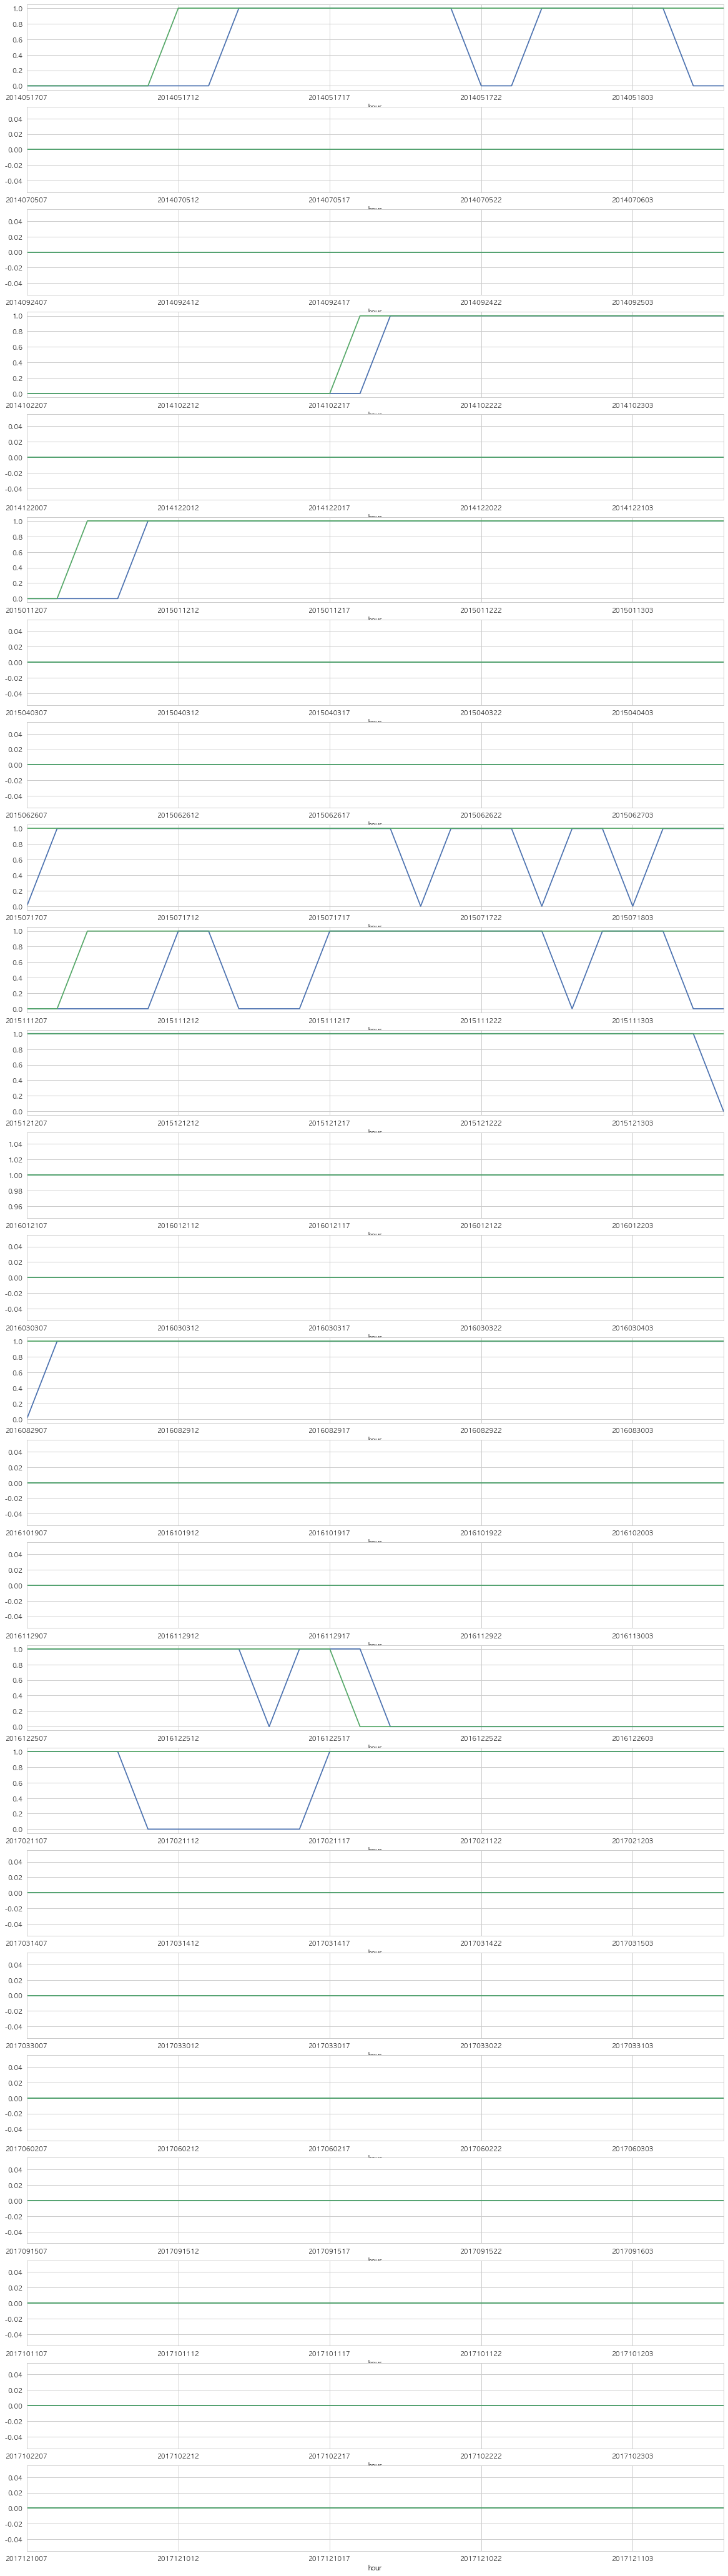

In [38]:
index = 0
for i in range(25):
    index = i*24
    plt.subplot(25,1,i+1)
    test.iloc[index:index+24]['pred_swell'].plot()
    real.iloc[index:index+24].plot()#.apply(lambda x:output_change(x)).plot()

In [39]:
index=0
test.iloc[index:index+24].T

hour,2014051707,2014051708,2014051709,2014051710,2014051711,2014051712,2014051713,2014051714,2014051715,2014051716,...,2014051721,2014051722,2014051723,2014051800,2014051801,2014051802,2014051803,2014051804,2014051805,2014051806
swell(t+1),0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
pred,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
pred_swell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
real_swell,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [40]:
#eval_metric = evaluation(df['swell(t+1)'].apply(output_change))
eval_metric = evaluation(df['swell(t+1)'].fillna(method='ffill'))

In [41]:
scores = []
for day in range(25):
    st = day*24
    print(st)
    scores.append(eval_metric.evaluate(test['pred_swell'][st:st + 24]))
    #print(test['pred_swell'][st:st+24].value_counts())

print(scores)

0
2    13
0     6
1     5
dtype: int64
24
1    24
dtype: int64
48
1    24
dtype: int64
72
2    12
1    11
0     1
dtype: int64
96
1    24
dtype: int64
120
2    20
1     2
0     2
dtype: int64
144
1    24
dtype: int64
168
1    24
dtype: int64
192
2    20
0     4
dtype: int64
216
 2    13
 0     8
 1     2
-2     1
dtype: int64
240
2    23
0     1
dtype: int64
264
2    24
dtype: int64
288
1    24
dtype: int64
312
2    23
0     1
dtype: int64
336
1    24
dtype: int64
360
1    24
dtype: int64
384
1    12
2    10
0     2
dtype: int64
408
 2    18
 0     4
-2     2
dtype: int64
432
1    24
dtype: int64
456
1    24
dtype: int64
480
1    24
dtype: int64
504
1    24
dtype: int64
528
1    24
dtype: int64
552
1    24
dtype: int64
576
1    24
dtype: int64
[31, 24, 24, 35, 24, 42, 24, 24, 40, 26, 46, 48, 24, 46, 24, 24, 32, 32, 24, 24, 24, 24, 24, 24, 24]


In [42]:
np.sum(scores)

738

In [43]:
imp_features

[['22453_파주기(sec)',
  '22105_수온(°C)',
  '21229_기온(°C)',
  '22106_습도(%)',
  '22106_유의파고(m)',
  '22106_파주기(sec)',
  '22105_기온(°C)',
  '22453_평균파고(m)',
  '22453_유의파고(m)',
  '21229_파향(deg)'],
 ['22453_파주기(sec)',
  '22105_수온(°C)',
  '21229_기온(°C)',
  '22106_유의파고(m)',
  '22106_습도(%)',
  '22453_유의파고(m)',
  '22105_기온(°C)',
  '21229_수온(°C)',
  '22106_기온(°C)',
  '22453_최대파고(m)'],
 ['22105_수온(°C)',
  '22453_파주기(sec)',
  '21229_기온(°C)',
  '22106_습도(%)',
  '22106_기온(°C)',
  '22105_기온(°C)',
  '22453_유의파고(m)',
  '21229_수온(°C)',
  '22453_최대파고(m)',
  '22106_파주기(sec)'],
 ['22105_수온(°C)',
  '22453_파주기(sec)',
  '21229_기온(°C)',
  '22106_기온(°C)',
  '22106_습도(%)',
  '21229_수온(°C)',
  '22106_파주기(sec)',
  '22453_평균파고(m)',
  '22105_기온(°C)',
  '22453_최대파고(m)'],
 ['22105_수온(°C)',
  '22453_파주기(sec)',
  '21229_기온(°C)',
  '22106_기온(°C)',
  '22453_유의파고(m)',
  '22106_습도(%)',
  '22106_파주기(sec)',
  '21229_수온(°C)',
  'lunar_ay_sin',
  '22105_기온(°C)'],
 ['22105_수온(°C)',
  '22453_파주기(sec)',
  '21229_기온(°C)',
  '22106_기온(°C

### parameter

| index | n_estimators | fl_score | acc |class2_f1_score| class2_acc | eval_score | detail|
| --- | --- | --- |--- |--- |--- |
|1 | 10 | 89 | 89|93|82|706| [21, 24, 24, 33, 24, 40, 24, 24, 38, 34, 39, 40, 24, 44, 24, 20, 31, 32, 22, 24, 24, 24, 24, 24, 24]|
|2|30|92|92|95.7|89|745|[30, 24, 24, 32, 24, 40, 24, 24, 44, 38, 42, 46, 24, 46, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]|
|3|30|92|92|95.3|88.4|738|[32, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 44, 24, 44, 24, 20, 34, 36, 22, 24, 24, 24, 24, 24, 24]
|4|30|93|93|95.2|88.4|737|[30, 24, 24, 32, 24, 42, 24, 24, 42, 36, 41, 46, 24, 44, 24, 20, 34, 38, 20, 24, 24, 24, 24, 24, 24]
|5|50|92|92|95.0|86.9|730|[23, 24, 24, 29, 24, 40, 24, 24, 42, 36, 43, 46, 24, 44, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]
|6|50|91.8|91.8|95.3|88.4|735|[27, 24, 24, 31, 24, 40, 24, 24, 42, 40, 41, 44, 24, 44, 24, 20, 32, 38, 24, 24, 24, 24, 24, 24, 24]
|7|50|93|93|96|90|744|[33, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 46, 24, 44, 24, 22, 33, 38, 22, 24, 24, 24, 24, 24, 24]
|8|100|93|93|95.7|89.3|744|[26, 24, 24, 33, 24, 40, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 38, 24, 24, 24, 24, 24, 24, 24]
|9|100|93|93|96.8|91.7|750|[29, 24, 24, 33, 24, 42, 24, 24, 44, 36, 46, 46, 24, 44, 24, 22, 34, 38, 24, 24, 24, 24, 24, 24, 24]
|10|100|94|93.9|96.5|92.2|752|[35, 24, 24, 33, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 33, 38, 20, 24, 24, 24, 24, 24, 24]
|11|150|93|93|95.8|90.3|745|[32, 24, 24, 33, 24, 42, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 34, 22, 24, 24, 24, 24, 24, 24]
|12|150|93.6|93.6|96.7|91.3|753|[35, 24, 24, 31, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 34, 36, 24, 24, 24, 24, 24, 24, 24]|
|13|150|93.8|93.8|96.5|91.3|754|[36, 24, 24, 33, 24, 42, 24, 24, 42, 40, 41, 46, 24, 44, 24, 22, 34, 40, 22, 24, 24, 24, 24, 24, 24]
|14|200|92.6|92.6|95.5|88.8|736|[28, 24, 24, 33, 24, 40, 24, 24, 44, 36, 43, 46, 24, 44, 24, 20, 34, 34, 22, 24, 24, 24, 24, 24, 24]
|15|200|94|94|96.8|92.2|756|[35, 24, 24, 33, 24, 42, 24, 24, 44, 40, 45, 46, 24, 44, 24, 22, 33, 36, 24, 24, 24, 24, 24, 24, 24]
|16|200|92.8|92.8|95.7|89.3|741|[34, 24, 24, 33, 24, 40, 24, 24, 44, 40, 41, 46, 24, 44, 24, 22, 33, 30, 22, 24, 24, 24, 24, 24, 24]